In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/k_martel/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
######Importation des données##########

X=pd.read_csv("stats_fight_mma_division.csv",
                   sep='\t',index_col=0,header=None,usecols=[0,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,
                                                            20,21,22,23,24,25,26,27,28,29],engine='python')


y = pd.read_csv("stats_fight_mma_division.csv", sep='\t',header=None,engine='python',index_col=0, usecols=[0,30]).values.ravel()

columns=["POIDS A","TAILLE A","ANNEE A","EXPERIENCE A","VICTOIRE A","DEFAITE A","KO A",
           "SOUMISSION A","STREAK A","POIDS B","TAILLE B","ANNEE B","EXPERIENCE B","VICTOIRE B","DEFAITE B","KO B",
           "SOUMISSION B","STREAK B","DIFF POIDS","DIFF TAILLE","DIFF AGE","DIFF VICTOIRE","DIFF DEFAITE",
           "DIFF KO","DIFF SOUMISSION","DIFF STREAK"]
#transformation en matrice Numpy
X = X.values

X, X_test, y, y_test = train_test_split(X, y, test_size=0.33)

In [3]:
#Utilisaton de la librairie XGBOOST et de son classifieur
clf = XGBClassifier(base_score=0.005)
clf.fit(X, y)

XGBClassifier(base_score=0.005, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

[ 3  4  5  8  9 13 14 17 18 20 21 22]


(12,)

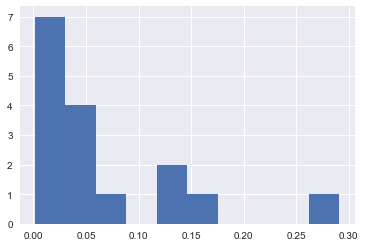

In [4]:
# Selection des bons features
plt.hist(clf.feature_importances_[clf.feature_importances_>0])
important_indices = np.where(clf.feature_importances_>0.005)[0]
print(important_indices)
important_indices.shape

In [5]:
elements_retenu=[]
for i in important_indices:
    elements_retenu.append(columns[i])
elements_retenu

['EXPERIENCE A',
 'VICTOIRE A',
 'DEFAITE A',
 'STREAK A',
 'POIDS B',
 'VICTOIRE B',
 'DEFAITE B',
 'STREAK B',
 'DIFF POIDS',
 'DIFF AGE',
 'DIFF VICTOIRE',
 'DIFF DEFAITE']

In [6]:
#Cross validation 
#en conservant 3 sous echantillons avec des fréquences de classes homogènes dans chacun des sous ensembles
clf = XGBClassifier(max_depth=5, base_score=0.005)
cv = StratifiedKFold(y, n_folds=3)
preds = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    preds[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:,1]
    print("fold {}, ROC AUC: {:.5f}".format(i, roc_auc_score(y[test], preds[test])))
print(roc_auc_score(y, preds))

fold 0, ROC AUC: 0.65088
fold 1, ROC AUC: 0.65150
fold 2, ROC AUC: 0.65054
0.65101248242


/Users/k_martel/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


0.215687108492


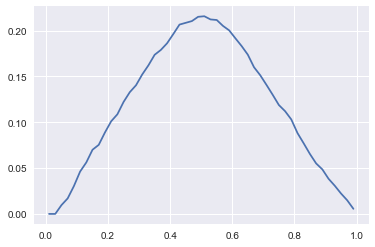

In [7]:
# on récupéere le meilleur seuil pour avoir le meilleur prédicteur selon le critère du coefficient de Mattews
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(y, preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [8]:
# generate predictions at the chosen threshold
preds = (clf.predict_proba(X_test)[:,1] > best_threshold).astype(np.int8)

In [9]:
# Comparaison des predictions avec les vraies valeurs
print("ROC AUC: {:.5f}".format(roc_auc_score(y_test, preds)))

ROC AUC: 0.60920
